In [1]:
import torch
import pickle as pkl
import pandas as pd
import matplotlib
import glob
import json
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import torch.nn.functional as F
%matplotlib inline

In [2]:
os.chdir('/tmp/eigentasks')
from data.taskonomy import TaskonomyDataset, taskonomy_flat_split_to_buildings
from guided_filter.box_filter import BoxFilter

### Set up data

In [6]:
# Load data
opts = TaskonomyDataset.Options(
        data_path = '/datasets/taskonomy',
        tasks = ['rgb', 'depth_euclidean', 'depth_zbuffer'],
        buildings = 'debug-val',
        force_refresh_tmp=False
)

df = TaskonomyDataset(opts)


Loaded 2863 images from /datasets/taskonomy in 0.02 seconds
	 (1 buildings) (519 points) (2863 images) for domains ['rgb', 'depth_euclidean', 'depth_zbuffer']


Loaded TaskonomyDataset with 2863 images from tmp.


In [7]:
def show(im, noshow=False):
    n_im = 1
    if isinstance(im, list):
        n_im = len(im)
        im = [np.concatenate([i] * 3, 0) if i.shape[0] == 1 else i for i in im]
        im = np.concatenate(im, axis=2)
    plt.figure(figsize=(8 * n_im,8))
    im = np.transpose(im, [1,2,0])
    plt.imshow(im)
    if not noshow:
        plt.show()

In [13]:
# Load one image
res = df[10]
rgb = res['rgb']
depth = res['depth_euclidean']
depth_zbuffer = res['depth_zbuffer']
rgb = torch.Tensor(rgb).unsqueeze(0)
depth[depth >= 1.0] = depth[depth < 1.0].max()
rgb_cuda = rgb.cuda()
depth_cuda = depth.cuda()

# Load a second image
res = df[12]
rgb2 = res['rgb']
depth2 = res['depth_euclidean']
depth_zbuffer2 = res['depth_zbuffer']
rgb2 = torch.Tensor(rgb2).unsqueeze(0)
depth2[depth2 >= 1.0] = depth2[depth2 < 1.0].max()

rgb2 = rgb2
depth2 = depth2
rgb_cuda2 = rgb2.cuda()
depth_cuda2 = depth2.cuda()

In [14]:
# Form a CPU batch and a GPU batch
rgb_batch_cuda = torch.cat([rgb_cuda, rgb_cuda2], dim=0)
depth_batch_cuda = torch.cat([depth_cuda, depth_cuda2], dim=0)

rgb_batch = torch.cat([rgb, rgb2], dim=0)
depth_batch = torch.cat([depth, depth2], dim=0)

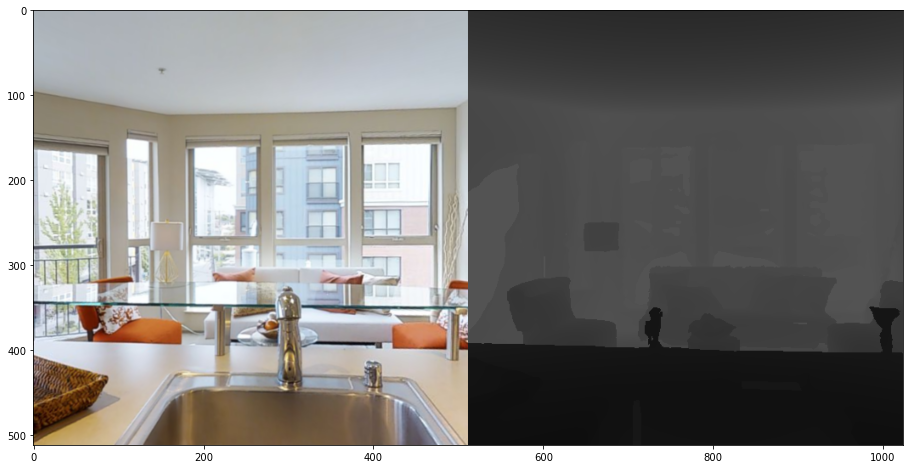

In [16]:
# Show a pretty image
show([rgb[0], depth])

###  Define filters

In [18]:
def gaussian(M, std, sym=True, device=None):
    if M < 1:
        return torch.tensor([])
    if M == 1:
        return torch.ones((1,))
    odd = M % 2
    if not sym and not odd:
        M = M + 1
    n = torch.arange(0, M, device=device) - (M - 1.0) / 2.0
    sig2 = 2 * std * std
    w = torch.exp(-n ** 2 / sig2)
    if not sym and not odd:
        w = w[:-1]
    return w

def separable_gaussian(img, r=3.5, cutoff=None, device=None):
#         return img
    if device is None:
        device = img.device
    if r < 1e-1:
        return img
    if cutoff is None:
        cutoff = int(r * 5)
        if (cutoff % 2) == 0: cutoff += 1

    assert (cutoff % 2) == 1
    img = img.to(device)
    _, n_channels, w, h = img.shape
    std = r
    fil = gaussian(cutoff, std, device=device).to(device)
    filsum = fil.sum() #/ n_channels
    fil = torch.stack([fil] * n_channels, dim=0)
    r_pad = int(cutoff) 
    r_pad_half = r_pad // 2

    
    img = F.pad(img, (r_pad_half, r_pad_half, r_pad_half, r_pad_half), "replicate", 0)  # effectively zero padding
    filtered = F.conv2d(img, fil.unsqueeze(1).unsqueeze(-2), bias=None, stride=1, padding=0, dilation=1, groups=n_channels)
    filtered /= filsum
    filtered = F.conv2d(filtered, fil.unsqueeze(1).unsqueeze(-1), bias=None, stride=1, padding=0, dilation=1, groups=n_channels)
    filtered /= filsum

    return filtered

def boxblur(img, r):
    _, _, w, h = img.shape
    f = BoxFilter(r)
    r_pad = int(r * 2)
    r_pad_half = r_pad // 2
    im = F.pad(img, (r_pad_half, r_pad_half, r_pad_half, r_pad_half), "replicate", 0)  # effectively zero padding
    filtered = f(im)
    filtered = filtered[..., r_pad_half:w+r_pad_half, r_pad_half:h+r_pad_half]
    filtered /= ((2 * r + 1) ** 2)
    return filtered


#### Circle of confusion formula
LHS is circle of confusion, RHS is magnification


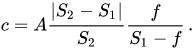

In [ ]:
import torch
from torch.nn.parallel import parallel_apply

In [61]:

def compute_circle_of_confusion(depths, aperture_size, focal_length, focus_distance):
    assert focus_distance > focal_length
    c = aperture_size * torch.abs(depths - focus_distance) / depths * (focal_length / (focus_distance - focal_length))
    return c


def compute_circle_of_confusion_no_magnification(depths, aperture_size, focus_distance):
    c = aperture_size * torch.abs(depths - focus_distance) / depths 
    return c


def compute_quantiles(depth, quantiles, eps=0.0001):
    depth_flat = depth.reshape(depth.shape[0], -1)
    quantile_vals = torch.quantile(depth_flat, quantiles, dim=1)
    quantile_vals[0] -= eps
    quantile_vals[-1] += eps
    return quantiles, quantile_vals


def compute_quantile_membership(depth, quantile_vals):
    quantile_dists = quantile_vals[1:]  - quantile_vals[:-1]
    depth_flat = depth.reshape(depth.shape[0], -1)
    calculated_quantiles = torch.searchsorted(quantile_vals, depth_flat)
    calculated_quantiles_left = calculated_quantiles - 1
    quantile_vals_unsqueezed = quantile_vals #.unsqueeze(-1).unsqueeze(-1)
    quantile_right = torch.gather(quantile_vals_unsqueezed, 1, calculated_quantiles).reshape(depth.shape)
    quantile_left = torch.gather(quantile_vals_unsqueezed, 1, calculated_quantiles_left).reshape(depth.shape)
    quantile_dists = quantile_right - quantile_left

    dist_right = ((quantile_right - depth) / quantile_dists) #/ quantile_dists[calculated_quantiles_left]
    dist_left = ((depth - quantile_left) / quantile_dists)  #/ quantile_dists[calculated_quantiles_left]
    return dist_left, dist_right, calculated_quantiles_left.reshape(depth.shape), calculated_quantiles.reshape(depth.shape)

def get_blur_stack_single_image(rgb, blur_radii, cutoff_multiplier):
    args = []
    for r in blur_radii:
        cutoff = None if cutoff_multiplier is None else int(r * cutoff_multiplier)
        if cutoff is not None and (cutoff % 2) == 0:
            cutoff += 1
        args.append((rgb, r, cutoff))
    
    blurred_ims = parallel_apply([separable_gaussian]*len(args), args)
    blurred_ims = torch.stack(blurred_ims, dim=1)
    return blurred_ims

def get_blur_stack(rgb, blur_radii, cutoff_multiplier=None):
    args = [(image.unsqueeze(0), radii, cutoff_multiplier) for image, radii in zip(rgb, blur_radii)]
    modules = [get_blur_stack_single_image for _ in args]
    outputs = parallel_apply(modules, args)
    return torch.cat(outputs, dim=0)


def composite_blur_stack(blur_stack, dist_left, dist_right, values_left, values_right):
    shape = list(blur_stack.shape)
    shape[2] = 1
    composite_vals = torch.zeros(shape, dtype=torch.float32, device=blur_stack.device)
    sim_left = (1 - dist_left**2)
    sim_right = (1 - dist_right**2)

    _ = composite_vals.scatter_(1, index=values_left.unsqueeze(1).unsqueeze(2), src=sim_left.unsqueeze(1).unsqueeze(2))
    _ = composite_vals.scatter_(1, index=values_right.unsqueeze(1).unsqueeze(2), src=sim_right.unsqueeze(1).unsqueeze(2))
    
    composite_vals /= composite_vals.sum(dim=1, keepdims=True)
    composited = composite_vals * blur_stack
    composited = composited.sum(dim=1)
    return composited


def refocus_image(rgb, depth, focus_distance, aperture_size, quantile_vals, return_segments=False):
    quantile_vals_squeezed = quantile_vals.squeeze()
    dist_left, dist_right, calculated_quantiles_left, calculated_quantiles = compute_quantile_membership(depth, quantile_vals)
    blur_radii = compute_circle_of_confusion_no_magnification(quantile_vals, aperture_size, focus_distance)

    # print(f'Quantiles: {quantile_vals}')
    # print(f'Blurs: {blur_radii.shape}')

    blur_stack = get_blur_stack(rgb, blur_radii, cutoff_multiplier=3)
    composited = composite_blur_stack(blur_stack, dist_left, dist_right, calculated_quantiles_left, calculated_quantiles)

    if return_segments:
        return composited, calculated_quantiles_left
    else:
        return composited

##########################################
#
##########################################

def RefocusImageAugmentation(n_quantiles, aperture_min, aperture_max, return_segments=False):
    '''
        RefocusImageAugmentation
            Given an RGB image and depth image, refocuses the RGB image by blurring according to depth.
            - Based on a paraxial thin-lens model for refocusing.
            - Bands the depth image into segments of equal size (size given by n_quantiles)
            - Finds blur corresponding to each depth segment cutoff
            - Creates "blur stack" of n_quantiles + 1 blurred image (separable Gaussian filter)
            - For each depth location, composite pixel value as interpolation between two of the 
                blur images from the stack           
        
            Randomly selects:
            - focus distance to be one of the quantiles (so that some of the image is always in focus).
            - aperture_size log-uniformly from [aperture_min, aperture_max]

        Arguments:
            n_quantiles: How many quantiles to use in the blur stack. More is better, but slower
            aperture_min: Smallest aperture to use
            aperture_max: Largest aperture to use (randomly selects one log-uniformly in this range)
            return_segments: whether to return the depth segments
    '''
    def refocus_image_(rgb, depth):
        with torch.no_grad():
            device = depth.device
            quantiles = torch.arange(0, n_quantiles + 1, device=device) / n_quantiles
            quantiles, quantile_vals = compute_quantiles(depth, quantiles, eps=0.0001)
            quantile_vals = quantile_vals.permute(1, 0)

            focus_dist_idxs = torch.randint(low=1, high=n_quantiles, size=(rgb.shape[0],), device=device)
            focus_dists = torch.gather(quantile_vals, 1, focus_dist_idxs.unsqueeze(0)).permute(1,0)

            log_min = torch.log(torch.tensor(aperture_min, device=device))
            log_max = torch.log(torch.tensor(aperture_max, device=device))

            apertures = torch.exp(
                            torch.rand(size=(rgb.shape[0],1), device=device) 
                            * (log_max - log_min) + log_min
                        )
            # print(f'dist: {focus_dists}, apertures: {apertures}')
            return refocus_image(rgb, depth, focus_dists, apertures, quantile_vals, return_segments)
    return refocus_image_


In [64]:
# Example usage
n_quantiles = 8
aug = RefocusImageAugmentation(8, 0.01, 3.0, return_segments=True)
composited, calculated_quantiles_left = aug(rgb_batch_cuda, depth_batch_cuda)

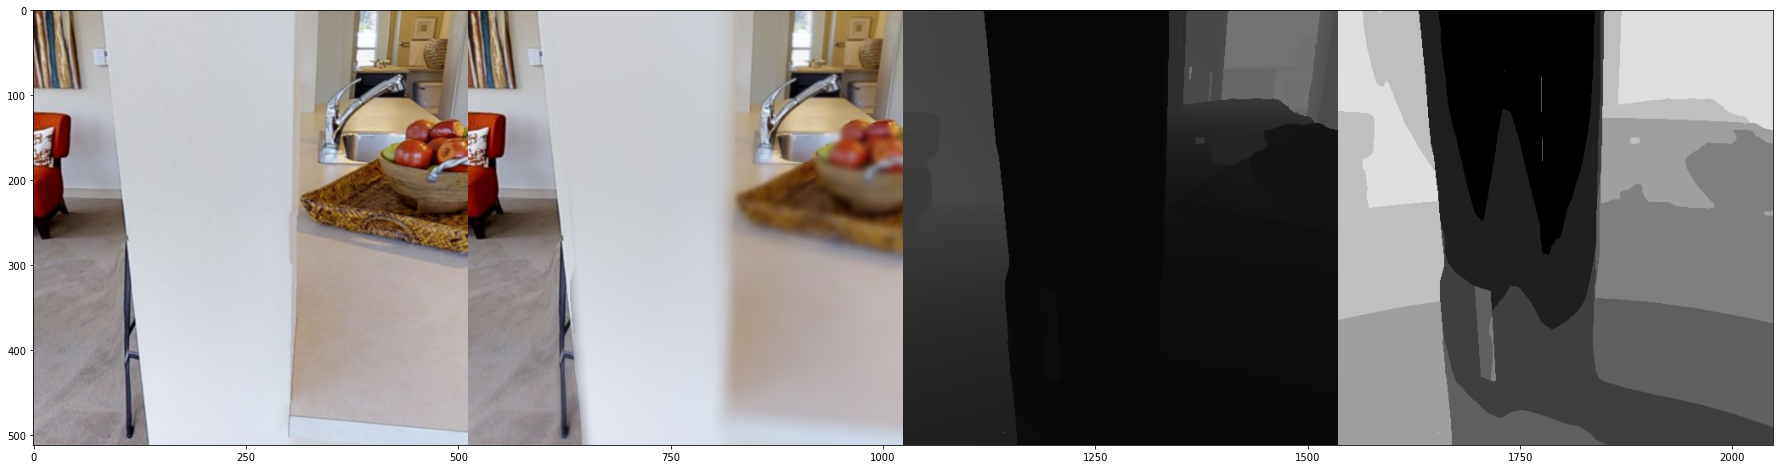

In [65]:
k = 1
show([rgb_batch[k],
      composited[k].detach().cpu(),
      depth_batch[k].unsqueeze(0),
      calculated_quantiles_left[k].unsqueeze(0).detach().cpu() / n_quantiles])